# Project: Dog vs Cat Classification

In [106]:
from pathlib import Path
import os
import torch
from torch import nn

In [107]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [108]:
data_path = Path("data/")
train_path = data_path / "train"
test_path = data_path / "test"

train_path, test_path

(WindowsPath('data/train'), WindowsPath('data/test'))

In [109]:
from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np

Text(0.5, 1.0, 'Cat, Shape: (500, 476, 3)')

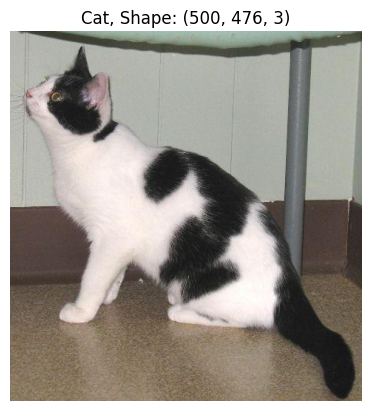

In [110]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
image_path_list = list(data_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)
img_is_array = np.asarray(img)

plt.imshow(img)
plt.axis(False)
plt.title(f"{image_class}, Shape: {img_is_array.shape}")

In [111]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [112]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [113]:
transformed_image = data_transform(img)
transformed_image

tensor([[[0.2824, 0.3294, 0.3725,  ..., 0.5961, 0.6706, 0.7098],
         [0.3490, 0.3412, 0.3294,  ..., 0.6941, 0.7098, 0.7137],
         [0.6235, 0.6196, 0.5765,  ..., 0.6941, 0.7137, 0.7137],
         ...,
         [0.4706, 0.3412, 0.1137,  ..., 0.5451, 0.5412, 0.5451],
         [0.4706, 0.4392, 0.2078,  ..., 0.5451, 0.5333, 0.5373],
         [0.4902, 0.4706, 0.3569,  ..., 0.5373, 0.5373, 0.5412]],

        [[0.3020, 0.3569, 0.4118,  ..., 0.6000, 0.6745, 0.7137],
         [0.3647, 0.3569, 0.3451,  ..., 0.6980, 0.7137, 0.7176],
         [0.6471, 0.6471, 0.6078,  ..., 0.6980, 0.7176, 0.7176],
         ...,
         [0.4157, 0.3137, 0.1176,  ..., 0.4784, 0.4745, 0.4824],
         [0.4235, 0.3882, 0.1922,  ..., 0.4824, 0.4706, 0.4784],
         [0.4196, 0.4118, 0.3216,  ..., 0.4745, 0.4784, 0.4824]],

        [[0.2353, 0.2902, 0.3529,  ..., 0.5765, 0.6510, 0.6902],
         [0.3137, 0.2941, 0.2863,  ..., 0.6745, 0.6902, 0.6941],
         [0.6039, 0.6000, 0.5569,  ..., 0.6745, 0.6941, 0.

Text(0.5, 1.0, 'Cat, Shape: torch.Size([3, 64, 64])')

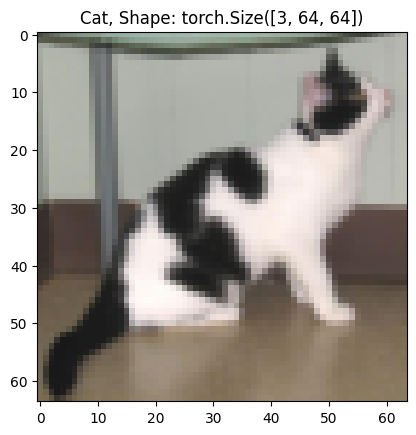

In [114]:
plt.imshow(transformed_image.permute(1, 2, 0))
plt.title(f"{image_class}, Shape: {transformed_image.shape}")

# Loading data using 'ImageFolder'

In [115]:
train_data = datasets.ImageFolder(root=train_path,
                                  transform=data_transform)

test_data = datasets.ImageFolder(root=test_path,
                                 transform=test_data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 10240
     Root location: data\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 2356
     Root location: data\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [116]:
# Get class names as list
class_names = train_data.classes
class_names

['Cat', 'Dog']

In [117]:
# Get class names as dictionary 
class_dict = train_data.class_to_idx
class_dict

{'Cat': 0, 'Dog': 1}

In [118]:
len(train_data), len(test_data)

(10240, 2356)

# Turn loaded images into 'DataLoader'

In [119]:
BATCH_SIZE = 32
NUM_WORKERS = 0

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1fb7a79cb50>,
 <torch.utils.data.dataloader.DataLoader at 0x1fb26cc27f0>)

In [120]:
img_custom, label_custom = next(iter(train_dataloader))

img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [121]:
class DogVsCat(nn.Module):
    def __init__(self, input_shape, hidden_layers, output_shape):
        super().__init__()

        self.conv_block_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_layers,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.BatchNorm2d(num_features=hidden_layers),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=hidden_layers,
                      out_channels=hidden_layers * 2,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.BatchNorm2d(num_features=hidden_layers*2),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.conv_block_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_layers*2,
                      out_channels=hidden_layers*2*2,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.BatchNorm2d(num_features=hidden_layers*2*2),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=hidden_layers*2*2,
                      out_channels=hidden_layers*2*2*2,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.BatchNorm2d(num_features=hidden_layers*2*2*2),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.classification = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_layers*16*16*8,
                      #out_features=output_shape
                      out_features=128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, output_shape)
        )

    def forward(self, x):
        #print(f"Shape: {x.shape}")
        x = self.conv_block_layer_1(x)
        #print(f"Shape: {x.shape}")
        x = self.conv_block_layer_2(x)
        #print(f"Shape: {x.shape}")
        x = self.classification(x)
        #print(f"Shape: {x.shape}")
        return x
        

In [122]:
model_0 = DogVsCat(input_shape=3, hidden_layers=16, output_shape=1).to(device)
model_0

DogVsCat(
  (conv_block_layer_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_layer_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6):

In [123]:
# Setup loss function and optimizer
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

loss_fn, optimizer

(BCEWithLogitsLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ))

In [124]:
# Check the correct shape on dummy tensor
dummy_input = torch.randn(32, 3, 64, 64)
output = model_0(dummy_input.to(device))
output

tensor([[-0.8566],
        [ 0.0380],
        [-0.1983],
        [ 0.0759],
        [-0.0911],
        [-0.1791],
        [-0.5261],
        [-0.1358],
        [-0.5896],
        [-0.2909],
        [-0.9297],
        [-0.4755],
        [ 0.1685],
        [ 0.0148],
        [-0.0122],
        [ 0.0526],
        [-0.3419],
        [ 0.0861],
        [ 0.0266],
        [ 0.1128],
        [ 0.0234],
        [-0.0355],
        [-0.7363],
        [-0.3662],
        [-0.2726],
        [ 0.0465],
        [ 0.2258],
        [-0.4914],
        [-0.8685],
        [-0.4194],
        [ 0.2626],
        [-0.5117]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [125]:
from tqdm import tqdm
import time

In [126]:
epochs = 1

start_time = time.time()

results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

for epoch in tqdm(range(epochs)):

    model_0.train()
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)

        y = y.unsqueeze(dim=1).float()
        
        y_pred = model_0(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = (torch.sigmoid(y_pred) > 0.5).float()
        train_acc += (y_pred_class==y).sum().item() / len(y_pred)

    train_loss /= len(train_dataloader)
    train_acc = (train_acc / len(train_dataloader)) * 100
    
    model_0.eval()
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_dataloader):
            X, y = X.to(device), y.to(device)

            y = y.unsqueeze(dim=1).float()
        
            test_pred = model_0(X)

            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            test_pred_class = (torch.sigmoid(test_pred) > 0.5).float()
            test_acc += (test_pred_class==y).sum().item() / len(test_pred)
    
        test_loss /= len(test_dataloader)
        test_acc = (test_acc / len(test_dataloader)) * 100

    print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f} | Test Loss: {test_loss}, Test Accuracy: {test_acc}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    


end_time = time.time()
train_time = end_time - start_time

print(f"Total time: {train_time}")

100%|██████████| 1/1 [00:36<00:00, 36.93s/it]

Epoch: 0 | Train Loss: 0.8380, Train Accuracy: 56.76 | Test Loss: 0.6480486328537399, Test Accuracy: 63.074324324324316
Total time: 36.932414531707764


# Plot model_0 results

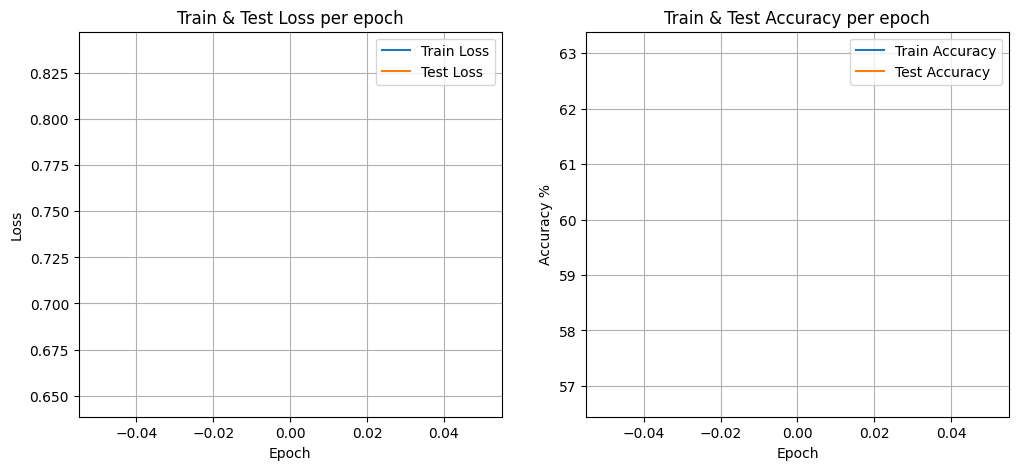

In [127]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), results["train_loss"], label="Train Loss")
plt.plot(range(epochs), results["test_loss"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Test Loss per epoch")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), results["train_acc"], label="Train Accuracy")
plt.plot(range(epochs), results["test_acc"], label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy %")
plt.title("Train & Test Accuracy per epoch")
plt.legend()
plt.grid()



In [128]:
print(len(results["train_loss"]), len(results["test_loss"]))
print(len(results["train_acc"]), len(results["test_acc"]))

1 1
1 1


In [129]:
# Build train and test function to make training easier
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim,
               device=device):

    train_loss, correct_preds, total_samples = 0, 0, 0
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y = y.unsqueeze(dim=1).float()
        
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        
        y_pred_class = (torch.sigmoid(y_pred) > 0.5).float()
        #train_acc += (y_pred_class==y).sum().item() / len(y_pred)
        correct_preds += (y_pred_class == y).sum().item()
        total_samples += y.size(0)

    train_loss /= len(dataloader)
    #train_acc = (train_acc / len(dataloader)) * 100
    train_acc = (correct_preds / total_samples) * 100
    
    return train_loss, train_acc

In [130]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):

    test_loss, correct_preds, total_samples = 0, 0, 0
    model.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            y = y.unsqueeze(dim=1).float()
        
            test_pred = model(X)

            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            test_pred_class = (torch.sigmoid(test_pred) > 0.5).float()
            #test_acc += (test_pred_class==y).sum().item() / len(test_pred)
            correct_preds += (test_pred_class == y).sum().item()
            total_samples += y.size(0)
    
    test_loss /= len(dataloader)
    #test_acc = (test_acc / len(dataloader)) * 100
    test_acc = (correct_preds / total_samples) * 100
    return test_loss, test_acc

# Augmentation data

In [131]:
train_data_transform_augmentation = transforms.Compose([
    #transforms.Resize(size=(64, 64)),
    transforms.RandomResizedCrop(size=(64, 64), scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=25),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    #transforms.RandomAffine(degrees=15, translate=(1, 1)),
    #transforms.TrivialAugmentWide(num_magnitude_bins=31), # used to differentiate the data
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

test_data = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
train_data_transform_augmentation, test_data

(Compose(
     RandomResizedCrop(size=(64, 64), scale=(0.9, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
     RandomHorizontalFlip(p=0.5)
     RandomRotation(degrees=[-25.0, 25.0], interpolation=nearest, expand=False, fill=0)
     ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.05, 0.05))
     GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))
     ToTensor()
     Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
 ),
 Compose(
     Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
     ToTensor()
     Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
 ))

In [132]:
train_data_augmentation = datasets.ImageFolder(root=train_path,
                                               transform=train_data_transform_augmentation)
test_data_augmentation = datasets.ImageFolder(root=test_path,
                                              transform=test_data)

train_data_augmentation, test_data_augmentation

(Dataset ImageFolder
     Number of datapoints: 10240
     Root location: data\train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(64, 64), scale=(0.9, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
                RandomHorizontalFlip(p=0.5)
                RandomRotation(degrees=[-25.0, 25.0], interpolation=nearest, expand=False, fill=0)
                ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.05, 0.05))
                GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))
                ToTensor()
                Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            ),
 Dataset ImageFolder
     Number of datapoints: 2356
     Root location: data\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.

In [133]:
BATCH_SIZE = 64
NUM_WORKERS = 4

train_dataloader_augmentation = DataLoader(dataset=train_data_augmentation,
                                           batch_size=BATCH_SIZE,
                                           num_workers=NUM_WORKERS,
                                           shuffle=True)

test_dataloader_augmentation = DataLoader(dataset=test_data_augmentation,
                                          batch_size=BATCH_SIZE,
                                          num_workers=NUM_WORKERS,
                                          shuffle=False)

train_dataloader_augmentation, test_dataloader_augmentation

(<torch.utils.data.dataloader.DataLoader at 0x1fb7afa0880>,
 <torch.utils.data.dataloader.DataLoader at 0x1fb7afa0fd0>)

In [134]:
len(class_names)

2

In [135]:
model_1 = DogVsCat(input_shape=3, hidden_layers=8, output_shape=1).to(device)
model_1

DogVsCat(
  (conv_block_layer_1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_layer_2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU

In [136]:
# Setup loss function and optimizer
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)
                             #lr=0.00025)
#optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01, momentum=0.9)
loss_fn, optimizer

(BCEWithLogitsLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ))

In [137]:
# Train model_1 on augmentation data
epochs = 50

start_time = time.time()

results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

for epoch in tqdm(range(epochs)):

    train_loss, train_acc = train_step(model=model_1,
               dataloader=train_dataloader_augmentation,
               loss_fn=loss_fn,
               optimizer=optimizer)

    test_loss, test_acc = test_step(model=model_1,
              dataloader=test_dataloader_augmentation,
              loss_fn=loss_fn)

    print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f} | Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    


end_time = time.time()
train_time = end_time - start_time

print(f"Total time: {train_time}")

  2%|▏         | 1/50 [00:44<36:07, 44.23s/it]

Epoch: 0 | Train Loss: 0.8248, Train Accuracy: 53.46 | Test Loss: 0.6854, Test Accuracy: 55.22


  4%|▍         | 2/50 [01:28<35:19, 44.15s/it]

Epoch: 1 | Train Loss: 0.6853, Train Accuracy: 55.60 | Test Loss: 0.6759, Test Accuracy: 59.93


  6%|▌         | 3/50 [02:11<34:18, 43.80s/it]

Epoch: 2 | Train Loss: 0.6774, Train Accuracy: 55.86 | Test Loss: 0.6755, Test Accuracy: 54.67


  8%|▊         | 4/50 [02:54<33:20, 43.49s/it]

Epoch: 3 | Train Loss: 0.6742, Train Accuracy: 56.05 | Test Loss: 0.6667, Test Accuracy: 60.14


 10%|█         | 5/50 [03:37<32:33, 43.41s/it]

Epoch: 4 | Train Loss: 0.6670, Train Accuracy: 57.19 | Test Loss: 0.6623, Test Accuracy: 60.99


 12%|█▏        | 6/50 [04:21<31:45, 43.31s/it]

Epoch: 5 | Train Loss: 0.6565, Train Accuracy: 58.23 | Test Loss: 0.6318, Test Accuracy: 63.33


 14%|█▍        | 7/50 [05:03<30:55, 43.15s/it]

Epoch: 6 | Train Loss: 0.6451, Train Accuracy: 60.02 | Test Loss: 0.6012, Test Accuracy: 69.06


 16%|█▌        | 8/50 [05:46<30:10, 43.10s/it]

Epoch: 7 | Train Loss: 0.6316, Train Accuracy: 62.21 | Test Loss: 0.5987, Test Accuracy: 70.25


 18%|█▊        | 9/50 [06:31<29:43, 43.51s/it]

Epoch: 8 | Train Loss: 0.6230, Train Accuracy: 64.03 | Test Loss: 0.5899, Test Accuracy: 72.24


 20%|██        | 10/50 [07:16<29:24, 44.12s/it]

Epoch: 9 | Train Loss: 0.6171, Train Accuracy: 64.94 | Test Loss: 0.5758, Test Accuracy: 71.90


 22%|██▏       | 11/50 [08:02<29:00, 44.64s/it]

Epoch: 10 | Train Loss: 0.6075, Train Accuracy: 66.10 | Test Loss: 0.5875, Test Accuracy: 71.52


 24%|██▍       | 12/50 [08:48<28:27, 44.93s/it]

Epoch: 11 | Train Loss: 0.6074, Train Accuracy: 65.52 | Test Loss: 0.5846, Test Accuracy: 72.07


 26%|██▌       | 13/50 [09:33<27:50, 45.14s/it]

Epoch: 12 | Train Loss: 0.5991, Train Accuracy: 67.17 | Test Loss: 0.5815, Test Accuracy: 70.25


 28%|██▊       | 14/50 [10:19<27:07, 45.21s/it]

Epoch: 13 | Train Loss: 0.5980, Train Accuracy: 66.36 | Test Loss: 0.5534, Test Accuracy: 73.39


 30%|███       | 15/50 [11:03<26:12, 44.93s/it]

Epoch: 14 | Train Loss: 0.5924, Train Accuracy: 67.35 | Test Loss: 0.5727, Test Accuracy: 73.17


 32%|███▏      | 16/50 [11:49<25:36, 45.19s/it]

Epoch: 15 | Train Loss: 0.5897, Train Accuracy: 68.01 | Test Loss: 0.5661, Test Accuracy: 75.04


 34%|███▍      | 17/50 [12:34<24:47, 45.08s/it]

Epoch: 16 | Train Loss: 0.5845, Train Accuracy: 68.30 | Test Loss: 0.5423, Test Accuracy: 73.98


 36%|███▌      | 18/50 [13:19<24:10, 45.31s/it]

Epoch: 17 | Train Loss: 0.5811, Train Accuracy: 69.09 | Test Loss: 0.5311, Test Accuracy: 75.38


 38%|███▊      | 19/50 [14:03<23:10, 44.85s/it]

Epoch: 18 | Train Loss: 0.5746, Train Accuracy: 69.42 | Test Loss: 0.5485, Test Accuracy: 73.34


 40%|████      | 20/50 [14:47<22:11, 44.39s/it]

Epoch: 19 | Train Loss: 0.5703, Train Accuracy: 70.01 | Test Loss: 0.5369, Test Accuracy: 73.09


 42%|████▏     | 21/50 [15:35<22:00, 45.52s/it]

Epoch: 20 | Train Loss: 0.5693, Train Accuracy: 70.23 | Test Loss: 0.5753, Test Accuracy: 68.89


 44%|████▍     | 22/50 [16:20<21:08, 45.31s/it]

Epoch: 21 | Train Loss: 0.5671, Train Accuracy: 70.36 | Test Loss: 0.5346, Test Accuracy: 73.26


 46%|████▌     | 23/50 [17:03<20:05, 44.63s/it]

Epoch: 22 | Train Loss: 0.5588, Train Accuracy: 70.71 | Test Loss: 0.5329, Test Accuracy: 73.60


 48%|████▊     | 24/50 [17:46<19:11, 44.28s/it]

Epoch: 23 | Train Loss: 0.5549, Train Accuracy: 70.95 | Test Loss: 0.5423, Test Accuracy: 72.58


 50%|█████     | 25/50 [18:30<18:22, 44.12s/it]

Epoch: 24 | Train Loss: 0.5475, Train Accuracy: 71.97 | Test Loss: 0.5038, Test Accuracy: 76.99


 52%|█████▏    | 26/50 [19:13<17:34, 43.94s/it]

Epoch: 25 | Train Loss: 0.5477, Train Accuracy: 71.38 | Test Loss: 0.5114, Test Accuracy: 74.53


 54%|█████▍    | 27/50 [19:57<16:48, 43.86s/it]

Epoch: 26 | Train Loss: 0.5484, Train Accuracy: 71.38 | Test Loss: 0.5069, Test Accuracy: 76.19


 56%|█████▌    | 28/50 [20:41<16:07, 43.96s/it]

Epoch: 27 | Train Loss: 0.5378, Train Accuracy: 72.87 | Test Loss: 0.4838, Test Accuracy: 78.14


 58%|█████▊    | 29/50 [21:25<15:25, 44.06s/it]

Epoch: 28 | Train Loss: 0.5355, Train Accuracy: 72.71 | Test Loss: 0.4847, Test Accuracy: 76.57


 60%|██████    | 30/50 [22:15<15:15, 45.77s/it]

Epoch: 29 | Train Loss: 0.5324, Train Accuracy: 72.46 | Test Loss: 0.5634, Test Accuracy: 72.03


 62%|██████▏   | 31/50 [23:10<15:19, 48.39s/it]

Epoch: 30 | Train Loss: 0.5205, Train Accuracy: 73.13 | Test Loss: 0.5042, Test Accuracy: 76.57


 64%|██████▍   | 32/50 [24:11<15:40, 52.24s/it]

Epoch: 31 | Train Loss: 0.5267, Train Accuracy: 73.06 | Test Loss: 0.4684, Test Accuracy: 79.33


 66%|██████▌   | 33/50 [24:59<14:26, 50.97s/it]

Epoch: 32 | Train Loss: 0.5251, Train Accuracy: 73.16 | Test Loss: 0.4665, Test Accuracy: 78.27


 68%|██████▊   | 34/50 [25:45<13:12, 49.53s/it]

Epoch: 33 | Train Loss: 0.5225, Train Accuracy: 73.52 | Test Loss: 0.5237, Test Accuracy: 76.61


 70%|███████   | 35/50 [26:32<12:09, 48.64s/it]

Epoch: 34 | Train Loss: 0.5179, Train Accuracy: 73.89 | Test Loss: 0.4993, Test Accuracy: 76.91


 72%|███████▏  | 36/50 [27:16<11:03, 47.41s/it]

Epoch: 35 | Train Loss: 0.5147, Train Accuracy: 73.77 | Test Loss: 0.4524, Test Accuracy: 80.01


 74%|███████▍  | 37/50 [28:01<10:04, 46.52s/it]

Epoch: 36 | Train Loss: 0.5092, Train Accuracy: 74.90 | Test Loss: 0.4462, Test Accuracy: 79.50


 76%|███████▌  | 38/50 [28:44<09:06, 45.56s/it]

Epoch: 37 | Train Loss: 0.5084, Train Accuracy: 74.42 | Test Loss: 0.4359, Test Accuracy: 80.77


 78%|███████▊  | 39/50 [29:29<08:20, 45.48s/it]

Epoch: 38 | Train Loss: 0.4992, Train Accuracy: 75.35 | Test Loss: 0.4676, Test Accuracy: 79.07


 80%|████████  | 40/50 [30:20<07:50, 47.00s/it]

Epoch: 39 | Train Loss: 0.4923, Train Accuracy: 75.11 | Test Loss: 0.4561, Test Accuracy: 79.75


 82%|████████▏ | 41/50 [31:04<06:54, 46.09s/it]

Epoch: 40 | Train Loss: 0.4999, Train Accuracy: 75.35 | Test Loss: 0.4210, Test Accuracy: 80.14


 84%|████████▍ | 42/50 [31:48<06:03, 45.49s/it]

Epoch: 41 | Train Loss: 0.4987, Train Accuracy: 74.64 | Test Loss: 0.4526, Test Accuracy: 79.33


 86%|████████▌ | 43/50 [32:31<05:14, 44.87s/it]

Epoch: 42 | Train Loss: 0.4976, Train Accuracy: 74.96 | Test Loss: 0.4520, Test Accuracy: 80.48


 88%|████████▊ | 44/50 [33:22<04:40, 46.73s/it]

Epoch: 43 | Train Loss: 0.4990, Train Accuracy: 75.06 | Test Loss: 0.4380, Test Accuracy: 80.05


 90%|█████████ | 45/50 [34:13<03:59, 48.00s/it]

Epoch: 44 | Train Loss: 0.4956, Train Accuracy: 75.55 | Test Loss: 0.4179, Test Accuracy: 80.86


 92%|█████████▏| 46/50 [34:58<03:07, 46.96s/it]

Epoch: 45 | Train Loss: 0.4882, Train Accuracy: 75.81 | Test Loss: 0.4408, Test Accuracy: 80.01


 94%|█████████▍| 47/50 [35:47<02:23, 47.71s/it]

Epoch: 46 | Train Loss: 0.4854, Train Accuracy: 76.42 | Test Loss: 0.4360, Test Accuracy: 81.11


 96%|█████████▌| 48/50 [36:37<01:36, 48.18s/it]

Epoch: 47 | Train Loss: 0.4833, Train Accuracy: 75.84 | Test Loss: 0.4110, Test Accuracy: 81.07


 98%|█████████▊| 49/50 [37:25<00:48, 48.18s/it]

Epoch: 48 | Train Loss: 0.4810, Train Accuracy: 76.40 | Test Loss: 0.4218, Test Accuracy: 80.39


100%|██████████| 50/50 [38:10<00:00, 45.82s/it]

Epoch: 49 | Train Loss: 0.4790, Train Accuracy: 76.47 | Test Loss: 0.4170, Test Accuracy: 81.83
Total time: 2290.966266155243


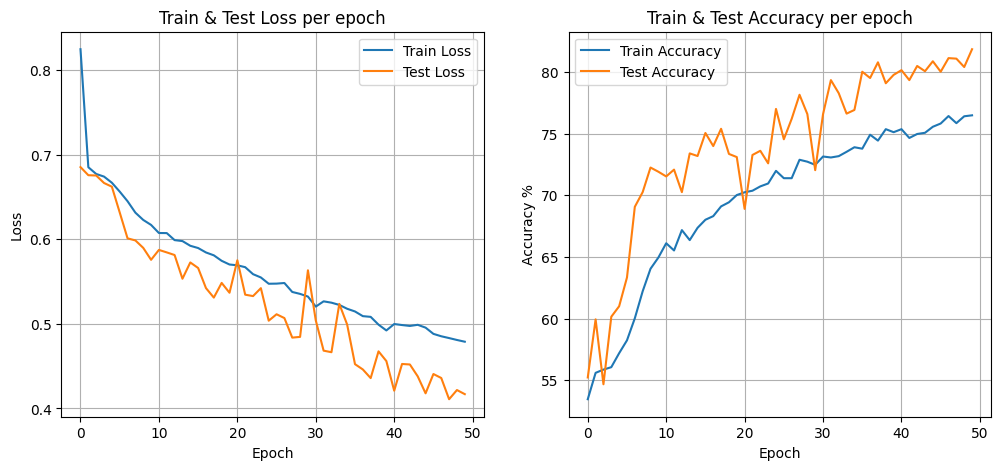

In [138]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), results["train_loss"], label="Train Loss")
plt.plot(range(epochs), results["test_loss"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Test Loss per epoch")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), results["train_acc"], label="Train Accuracy")
plt.plot(range(epochs), results["test_acc"], label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy %")
plt.title("Train & Test Accuracy per epoch")
plt.legend()
plt.grid()

In [139]:
from torch.utils.data import Subset

In [140]:
train_100_images = Subset(train_data_augmentation, range(100))
test_20_images = Subset(test_data_augmentation, range(20))

len(train_100_images), len(test_20_images)

(100, 20)